# Assignment 1

## Part 1 - Ridge Regression
#### Task 3.1: A function that can generate a random toy n-degree polynomial dataset of the form

Generated coefficients a_k: ['0.779', '0.416', '0.502']


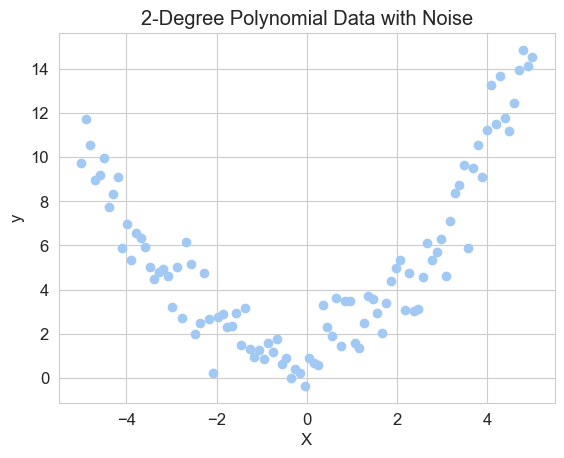

In [208]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ployData(degree,num_sample):
    # Generate `num_sample` data points x ∈ [−5, 5], reshape to column vector
    X = np.linspace(-5, 5, num_sample).reshape(-1, 1)

    # Randomly generate coefficients a_k ∼ U(0, 1) for a polynomial of given degree
    a = np.random.uniform(0, 1, degree + 1)

    # Generate Gaussian noise ε ∼ N(0, 1), shape = (num_sample, 1)
    e = np.random.randn(num_sample, 1)
    
    # Compute the polynomial values with noise
        # y = a_0 + a_1 * x + a_2 * x^2 + ... + a_n * x^n + ε
    y = np.sum([a[k] * (X**k) for k in range(degree + 1)], axis=0) + e

    return X, y, a

# ----- Test Data Generation -----
X, y, coeffs = gengerate_ployData(2, 100)

# Print the generated coefficients (rounded to 3 decimal places)
print(f"Generated coefficients a_k: {[f'{coeff:.3f}' for coeff in coeffs]}")

# Visualization
plt.scatter(X, y, color='#A1C9F4', label="Generated Data")
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'{degree}-Degree Polynomial Data with Noise')
plt.show()


### Task 3.2： Implement Ridge Regression

In [209]:
# Closed-form solution to minimize Ridge Regression cost function L(w)
def cfs_ridgeReg(X, y, alpha):
    # Apply the bias trick: add a column of 1s to X to handle the bias term separately
    X_bias = np.hstack([np.ones((X.shape[0], 1)),X])

    XtX = np.dot(X_bias.T, X_bias)

    XtY = np.dot(X_bias.T, y)

    # Create identity matrix for regularization, excluding bias term from regularization
    Im = np.identity(X_bias.shape[1])
    Im[0, 0] = 0 # Thebias-trick, set I(0,0) = 0

    # Compute the inverse of (X^T * X + α * I)
    XtX_alpha_Im_inv = np.linalg.pinv(XtX + alpha * Im)

    w = np.dot(XtX_alpha_Im_inv, XtY)
    
    # Return the computed coefficients (including bias term)

    return w

# ----- Run Custom Ridge Regression -----
w = cfs_ridgeReg(X, y, 0.1)

# Print the learned weights
print("Custom Ridge Regression : ", w)


Custom Ridge Regression :  [[5.24945574]
 [0.40522795]]


### Task 3.3: Generate three toy datasets

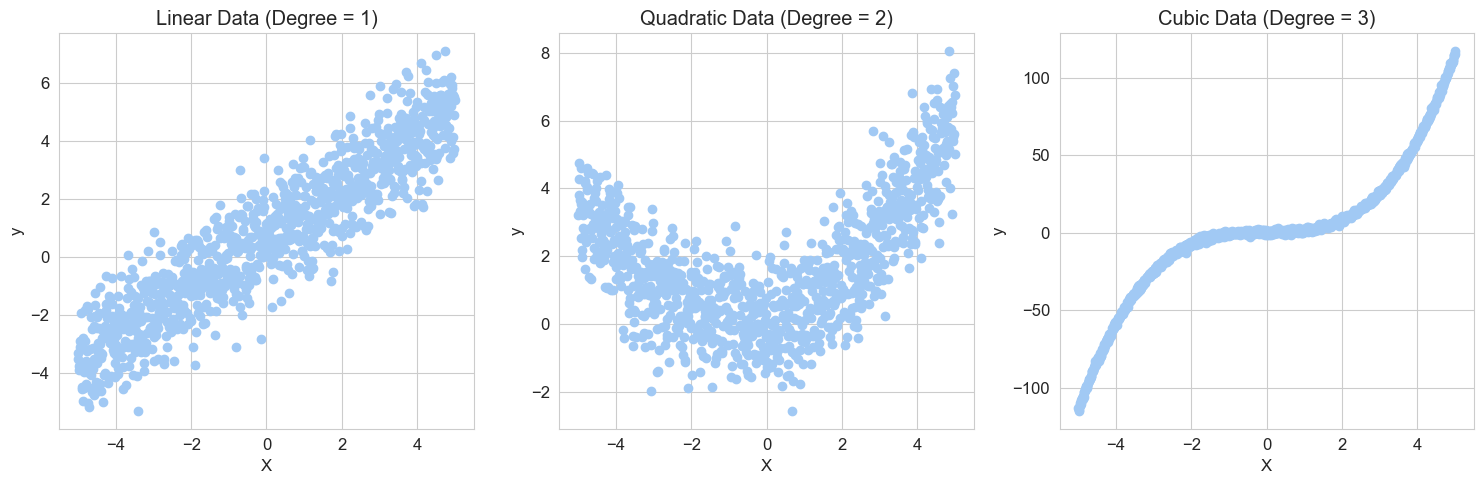

In [210]:

# a linear dataset（degree=1）
X_linear,y_linear, coeffs_linear = generate_ployData(degree=1, num_sample=1000)

# A quadratic dataset（degree=2）
X_quadratic,y_quadratic, coeffs_quadratic = generate_ployData(degree=2, num_sample=1000)

# A cubic dataset（degree=3）
X_cubic,y_cubic, coeffs_cubic = generate_ployData(degree=3, num_sample=1000)

# Visualize datasets of different polynomial degrees

plt.figure(figsize=(15, 5))

# Plot linear dataset (degree = 1)
plt.subplot(1, 3, 1)
plt.scatter(X_linear, y_linear, color='#A1C9F4', label='Linear data')
plt.title('Linear Data (Degree = 1)')
plt.xlabel('X')
plt.ylabel('y')

# Plot quadratic dataset (degree = 2)
plt.subplot(1, 3, 2)
plt.scatter(X_quadratic, y_quadratic, color='#A1C9F4', label='Quadratic data')
plt.title('Quadratic Data (Degree = 2)')
plt.xlabel('X')
plt.ylabel('y')

# Plot cubic dataset (degree = 3)
plt.subplot(1, 3, 3)
plt.scatter(X_cubic, y_cubic, color='#A1C9F4', label='Cubic data')
plt.title('Cubic Data (Degree = 3)')
plt.xlabel('X')
plt.ylabel('y')

plt.tight_layout()
plt.show()

### Task 3.4: Fit my model and sklearn.linear model.SGDRegressor on toy datasets

In [226]:
import numpy as np
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Define regularization parameters (alpha values)
alphas = [0, 0.1, 100]

# Build a function to compare there two model
def model_comparison(degree, num_sample, alphas):
    results = []
    
    for alpha in alphas:
        # Generate polynomial data of given degree and sample size
        X, y, _ = generate_ployData(degree, num_sample)

        # Generate polynomial features if degree > 1
        if degree > 1:
            poly = PolynomialFeatures(degree=degree, include_bias=False) # Do not Automatically add "constant terms" (that indicates bias intercept terms).
            X_poly = poly.fit_transform(X)
        else:
            X_poly = X
      

        # Turn y into a one-dimensional array (1D vector).
        y = y.ravel()
    
        # Custom implementation of Ridge Regression (closed-form solution)
        w_custom = cfs_ridgeReg(X_poly, y, alpha)
        coef_custom = w_custom[1:]

        # Ridge Regression using scikit-learn's implementation
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_poly, y)
        coef_ridge = ridge_model.coef_

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_poly)

        # Stochastic Gradient Descent Regressor (also supports regularization)
        sgd_model = SGDRegressor(alpha=max(alpha, 1e-3), max_iter=1000, penalty='l2', random_state=42)
        sgd_model.fit(X_scaled, y)
        coef_sgd = sgd_model.coef_
        
        # Predict using the custom model: y = Xw + b (bias term is w[0])
        y_pred_custom = X_poly @ w_custom[1:] + w_custom[0]
        
        # Predict using SGD model
        y_pred_sgd = sgd_model.predict(X_scaled)
        
        # Evaluate models using Mean Squared Error (MSE)
        mse_custom = mean_squared_error(y, y_pred_custom)
        mse_sgd = mean_squared_error(y, y_pred_sgd)
        
        results.append((X, y, y_pred_custom, y_pred_sgd, alpha, coef_custom, coef_ridge, coef_sgd, mse_custom, mse_sgd))

    return results

# Compare all models with different data complexities

# Linear data (Degree = 1)
results1 = model_comparison(1, 1000, alphas)
for res in results1:
    _, _, _, _, alpha, coef_custom, coef_ridge, coef_sgd, mse_custom, mse_sgd = res
    print("In A Linear Dataset")
    print(f"Regularization strength (alpha): {alpha}")
    print("Custom Ridge Coefficients (w):", coef_custom)
    print("Sklearn Ridge Coefficients (w):", coef_ridge)
    print("SGD Coefficients (w):", coef_sgd)
    print(f"MSE (Custom): {mse_custom:.3f}")
    print(f"MSE (SGD): {mse_sgd:.3f}")
    print("-" * 50)


# Quadratic data (Degree = 2)
results2 = model_comparison(2, 1000, alphas)
for res in results2:
    _, _, _, _, alpha, coef_custom, coef_ridge, coef_sgd, mse_custom, mse_sgd = res
    print("In A Quadratic Dataset")
    print(f"Regularization strength (alpha): {alpha}")
    print("Custom Ridge Coefficients (w):", coef_custom)
    print("Sklearn Ridge Coefficients (w):", coef_ridge)
    print("SGD Coefficients (w):", coef_sgd)
    print(f"MSE (Custom): {mse_custom:.3f}")
    print(f"MSE (SGD): {mse_sgd:.3f}")
    print("-" * 50)


# Cubic data (Degree = 3)
results3 = model_comparison(3, 1000, alphas)
for res in results3:
    _, _, _, _, alpha, coef_custom, coef_ridge, coef_sgd, mse_custom, mse_sgd = res
    print("In A Cubic Dataset")
    print(f"Regularization strength (alpha): {alpha}")
    print("Custom Ridge Coefficients (w):", coef_custom)
    print("Sklearn Ridge Coefficients (w):", coef_ridge)
    print("SGD Coefficients (w):", coef_sgd)
    print(f"MSE (Custom): {mse_custom:.3f}")
    print(f"MSE (SGD): {mse_sgd:.3f}")
    print("-" * 50)


In A Linear Dataset
Regularization strength (alpha): 0
Custom Ridge Coefficients (w): [0.09309654]
Sklearn Ridge Coefficients (w): [0.09309654]
SGD Coefficients (w): [0.2767591]
MSE (Custom): 0.953
MSE (SGD): 0.953
--------------------------------------------------
In A Linear Dataset
Regularization strength (alpha): 0.1
Custom Ridge Coefficients (w): [0.00487965]
Sklearn Ridge Coefficients (w): [0.00487965]
SGD Coefficients (w): [0.02533171]
MSE (Custom): 0.978
MSE (SGD): 0.978
--------------------------------------------------
In A Linear Dataset
Regularization strength (alpha): 100
Custom Ridge Coefficients (w): [0.8011572]
Sklearn Ridge Coefficients (w): [0.8011572]
SGD Coefficients (w): [0.01903624]
MSE (Custom): 0.979
MSE (SGD): 6.378
--------------------------------------------------
In A Quadratic Dataset
Regularization strength (alpha): 0
Custom Ridge Coefficients (w): [0.25504741 0.69606857]
Sklearn Ridge Coefficients (w): [0.25504741 0.69606857]
SGD Coefficients (w): [0.7312

### Task 3.5
#### (a) Comment on your choice of parameters for sklearn.linear model.SGDRegressor

In `SGDRegressor`, my choice of parameters:

1. alpha=max(alpha, 1e-3)
    - Meaning: Regularization strength (lambda).

    - Purpose: Controls how much penalty is applied to the model complexity.

    - Value: 0, 0.1, 100. Setting max(alpha, 1e-3) is to ensure the value is not too small (expecially 0), which could make the model unstable or overfit.

2. max_iter=1000
    - Meaning: Maximum number of iterations (epochs).

    - Purpose: Sets the number of training rounds over the data.

    - Value: 1000. It’s usually enough for small to medium-sized datasets. Helps ensure the model converges properly.

3. penalty='l2'
    - Meaning: Type of regularization (here: Ridge regularization).

    - Purpose: Penalizes large weights to prevent overfitting.

    - Value: 'l2'. Works well in most regression tasks, especially with high-dimensional data.

4. loss='squared_loss'
    - Meaning: The loss function to be minimized.

    - Value: squared_loss. squared_loss= Ordinary Least Squares = minimizes Mean Squared Error (MSE).


5. random_state=42
    - Meaning: Random seed.

    - Purpose: Ensures reproducibility of results (e.g., random shuffling, initialization).

    - Value: 42. A popular default number.


#### (b) Create scatter plots of your toy datasets. Plot your model and SGDRegressor. Compare w between the implementations.

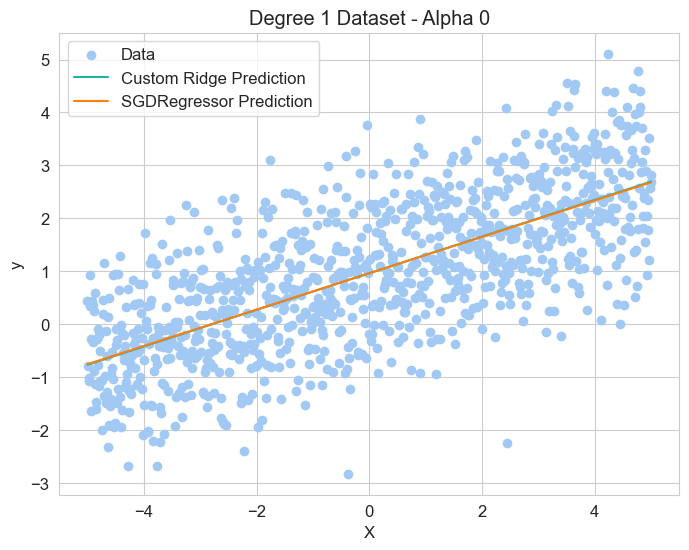

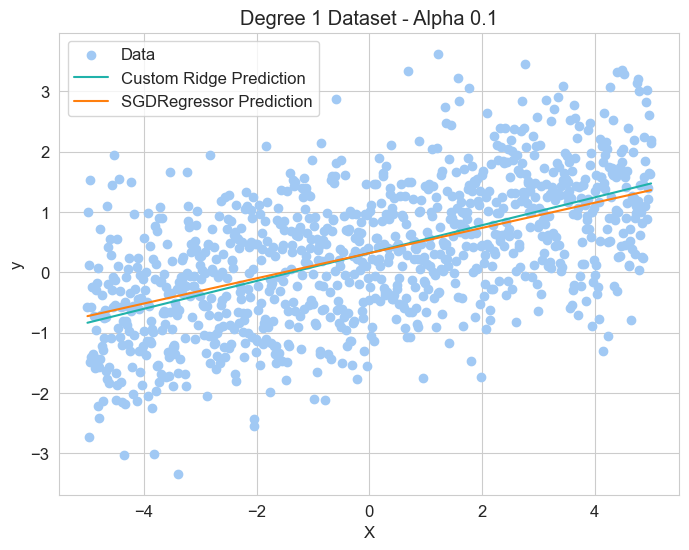

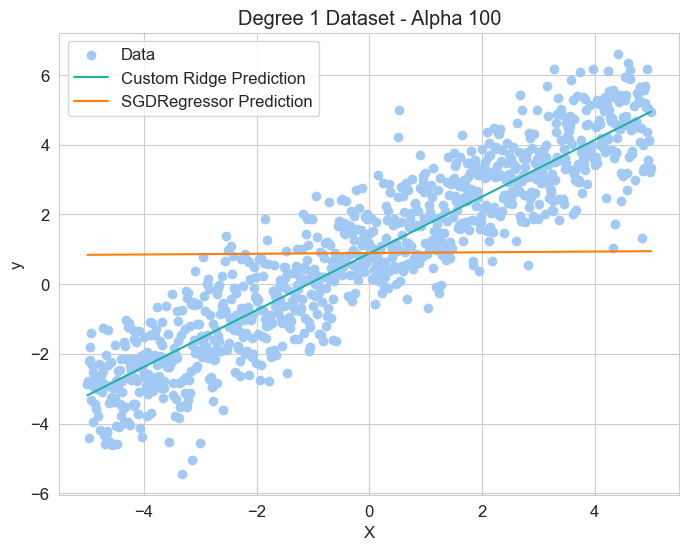

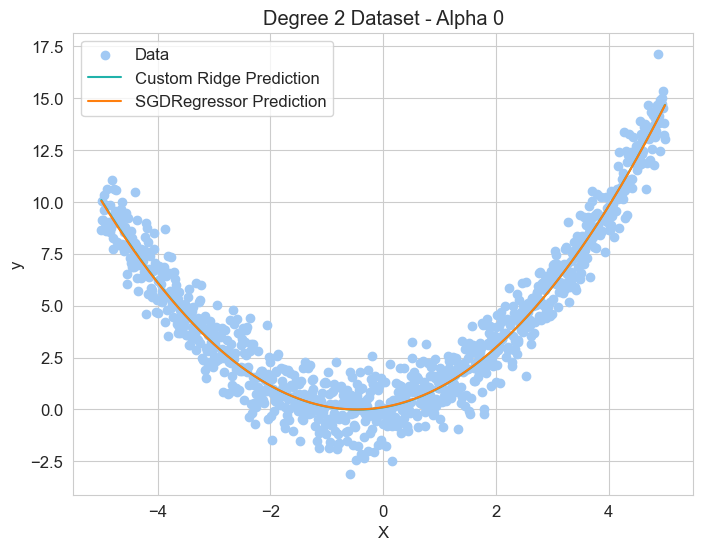

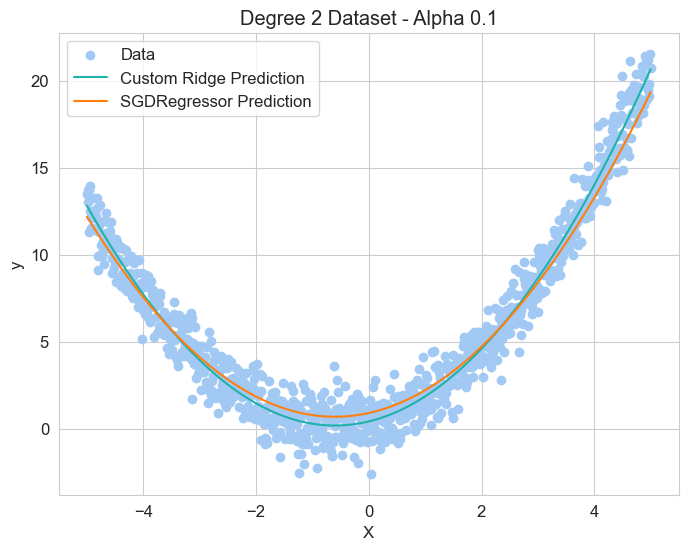

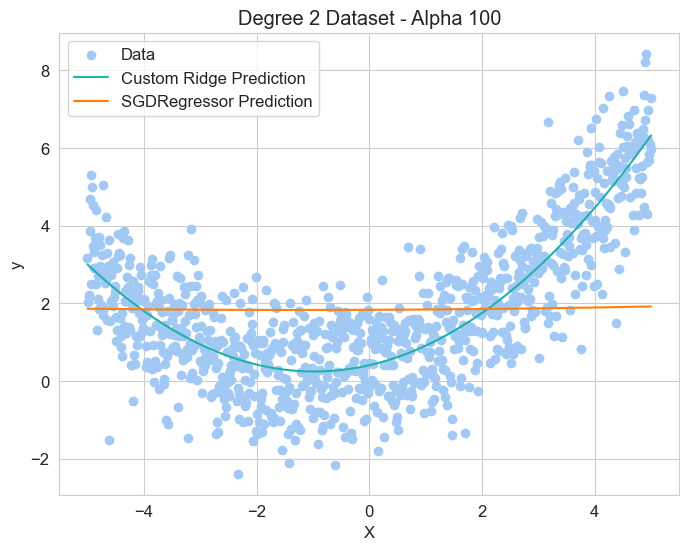

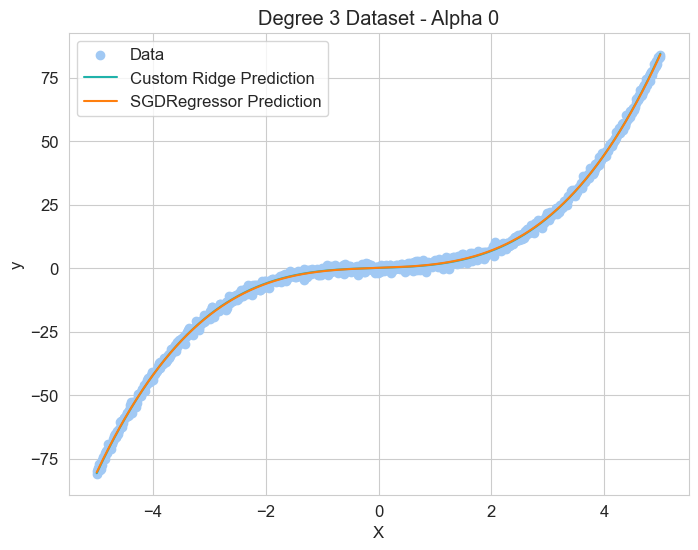

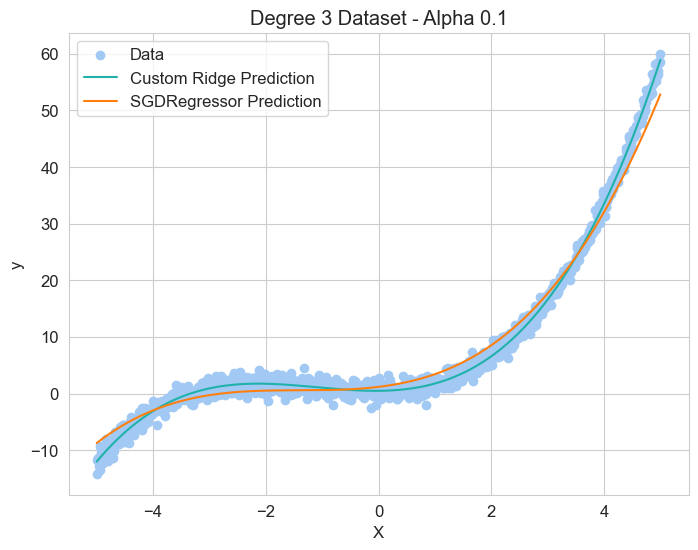

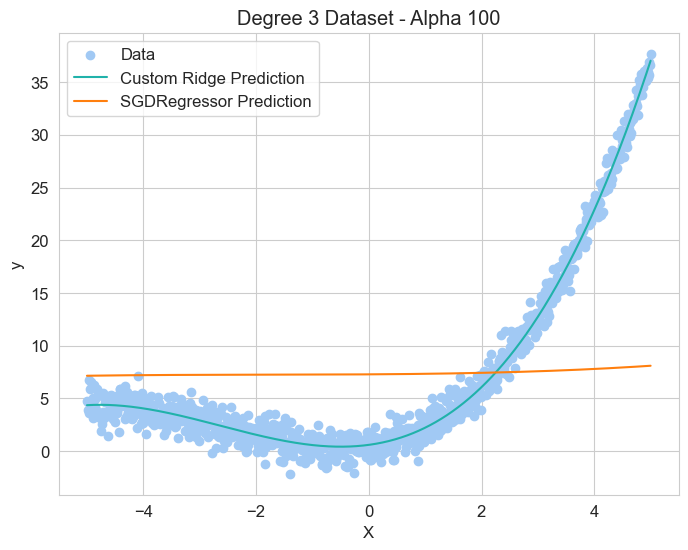

In [230]:
import numpy as np
import matplotlib.pyplot as plt


# Plot scatter for those compared models 
def plot_model_comparison(degree, num_sample, alphas):
    results = model_comparison(degree, num_sample, alphas)

    # Get the model data from model_comparison function
    for res in results:
        X, y, y_pred_custom, y_pred_sgd, alpha, _, _, _, _, _ = res
        
        # Sort to draw smooth curves
        sorted_idx = np.argsort(X[:, 0])
        x_sorted = X[sorted_idx, 0]
        y_custom_sorted = y_pred_custom[sorted_idx]
        y_sgd_sorted = y_pred_sgd[sorted_idx]

        # Plot the dataset and the model predictions
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], y, color='#A1C9F4', label='Data')
        plt.plot(x_sorted, y_custom_sorted, color='#20B2AA', label='Custom Ridge Prediction')
        plt.plot(x_sorted, y_sgd_sorted, color='#FF7F0E', label='SGDRegressor Prediction')

        plt.title(f"Degree {degree} Dataset - Alpha {alpha}")
        plt.xlabel("X")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.show()



# Define regularization strengths
alphas = [0, 0.1, 100]

# Plot the Compare models on three toy datasets
# Linear dataset
plot_model_comparison(1, 1000, alphas)

# Quadratic dataset
plot_model_comparison(2, 1000, alphas)

# Cubic dataset
plot_model_comparison(3, 1000, alphas)


#### (c) Is your implementation and scikit-learn’s producing the same output? Does α affect both models how you would expect?

**Compare model output:**

My implementation and SGDRegressor do not produce identical outputs, particularly with higher alpha values, where SGDRegressor shows more fluctuation. This suggests that SGDRegressor is more sensitive to hyperparameter choices and may require more tuning (e.g., increasing iterations, adjusting the learning rate).

1. Model Coefficients (w):

    - Custom Ridge Coefficients and Sklearn Ridge Coefficients are the same. This is because this model manually implemented Ridge regression using the closed-form solution, which matches the result from scikit-learn’s Ridge regression.

    - SGD Coefficients differ from the first two models. For example:

    At alpha=0, the coefficients of SGDRegressor are quite close to the custom Ridge model, but as alpha increases, the coefficients of SGDRegressor change significantly. This is expected because SGDRegressor uses iterative gradient descent optimization, whereas Ridge regression is computed using a closed-form solution.

2. Mean Squared Error (MSE):

    - Custom Ridge MSE and Sklearn Ridge MSE are generally similar and quite small (around 0.9), indicating that Ridge regression fits the model well on the training set.

    - SGD MSE shows more variation, especially at higher regularization strengths (like alpha=100), where the MSE increases significantly. This could be due to:

    Impact of Regularization Strength: SGDRegressor is based on gradient descent, so a very large regularization (alpha) could over-constrain the model, preventing it from reaching an optimal solution.

    Number of Iterations (max_iter): If the number of iterations is insufficient, SGDRegressor might not converge to the optimal solution, resulting in a higher MSE.

**Effect of α on the model:**

The impact of α is as expected.

1. α = 0 (no regularization):
    - Both models (custom Ridge and SGDRegressor) have very similar weights.
    - This shows that without regularization, the models give almost the same results.

2. α = 0.1 (a little regularization):
    - The weights and errors change a little, which means regularization is working — it helps reduce overfitting.
    - Both custom Ridge and sklearn’s Ridge show expected changes when α is added.

3. α = 100 (strong regularization):
    - When α is increased to 100, the regularization effect becomes more significant, and the weight is strongly penalized, resulting in a coefficient close to zero (especially for SGDRegressor), which indicates that regularization greatly inhibits model complexity.
    - For SGDRegressor, the regularization intensity (alpha) has a great influence on the model, and MSE increases significantly when alpha=100. This is because SGDRegressor requires multiple iterations to update the parameters, and too strong regularization may cause the model to fail to converge to the optimal solution, resulting in high errors.

### Task 3.6: Experiment with higher degree polynomials and larger values of n_samples:

As the degree of the polynomial and the number of samples increase, we can expect different behaviors for the models due to the increased complexity.

Degree 4 Dataset
Regularization strength (alpha): 0
Custom Ridge Coefficients (w): [0.7102314  0.45257132 0.0852894  0.17975781]
Sklearn Ridge Coefficients (w): [0.7102314  0.45257132 0.0852894  0.17975781]
SGD Coefficients (w): [ 2.0624145   3.91788369  4.02115454 29.462357  ]
MSE (Custom): 0.988
MSE (SGD): 1.014
--------------------------------------------------
Degree 4 Dataset
Regularization strength (alpha): 0.1
Custom Ridge Coefficients (w): [0.64331677 0.30456619 0.59620413 0.5279532 ]
Sklearn Ridge Coefficients (w): [0.64331677 0.30456619 0.59620413 0.5279532 ]
SGD Coefficients (w): [ 8.20177287 30.34503381 20.18072026 55.60327931]
MSE (Custom): 0.966
MSE (SGD): 108.712
--------------------------------------------------
Degree 4 Dataset
Regularization strength (alpha): 100
Custom Ridge Coefficients (w): [0.61790339 0.02292067 0.09546405 0.47336818]
Sklearn Ridge Coefficients (w): [0.61790339 0.02292067 0.09546405 0.47336818]
SGD Coefficients (w): [0.24178857 0.77452984 0.276497

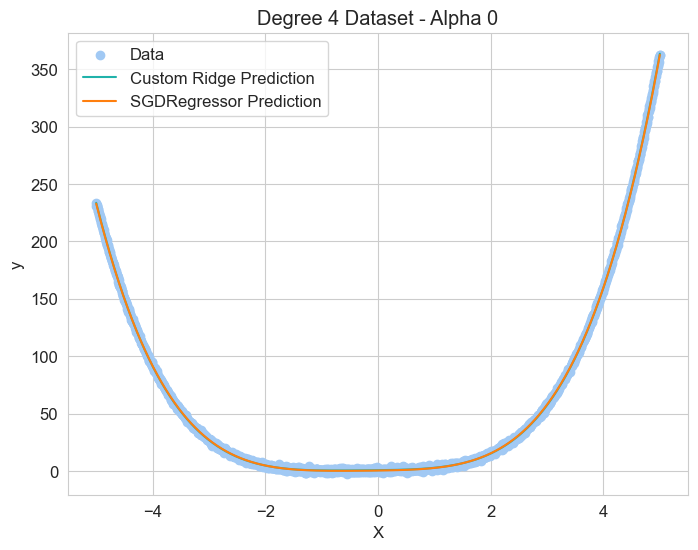

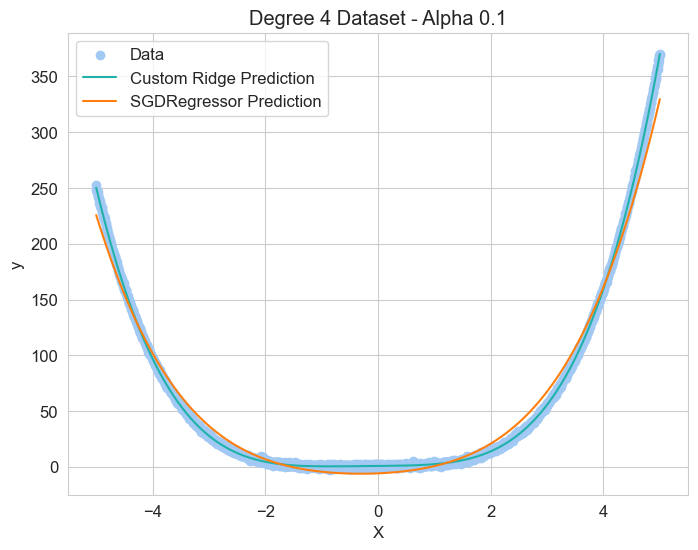

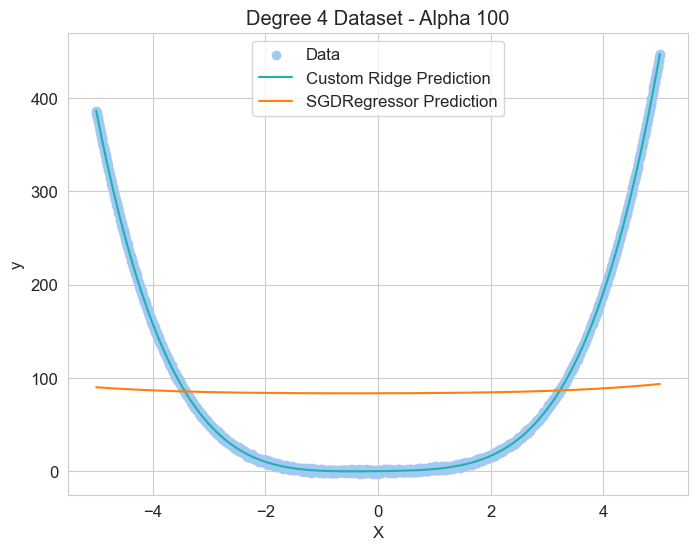

Degree 5 Dataset
Regularization strength (alpha): 0
Custom Ridge Coefficients (w): [0.25939911 0.37501346 0.65883566 0.00387394 0.56259196]
Sklearn Ridge Coefficients (w): [0.25939911 0.37501346 0.65883566 0.00387394 0.56259196]
SGD Coefficients (w): [-12.58100871   2.76703068  72.33026814   0.67085942 501.73766513]
MSE (Custom): 0.993
MSE (SGD): 15.199
--------------------------------------------------
Degree 5 Dataset
Regularization strength (alpha): 0.1
Custom Ridge Coefficients (w): [0.46923833 0.42357645 0.332949   0.02363859 0.1016499 ]
Sklearn Ridge Coefficients (w): [0.46923833 0.42357645 0.332949   0.02363859 0.1016499 ]
SGD Coefficients (w): [ 5.59776137  3.15248583 41.60268739  3.36552165 61.01587883]
MSE (Custom): 1.001
MSE (SGD): 105.646
--------------------------------------------------
Degree 5 Dataset
Regularization strength (alpha): 100
Custom Ridge Coefficients (w): [0.58541993 0.39305579 0.85688875 0.69101162 0.31768037]
Sklearn Ridge Coefficients (w): [0.58541993 0.

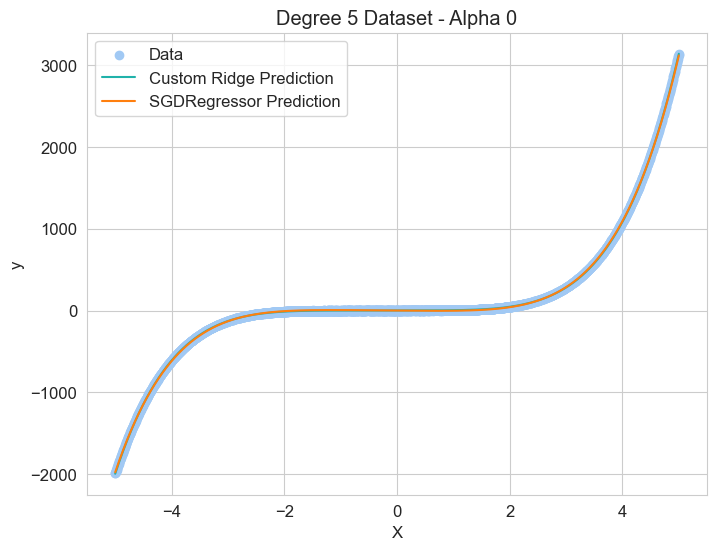

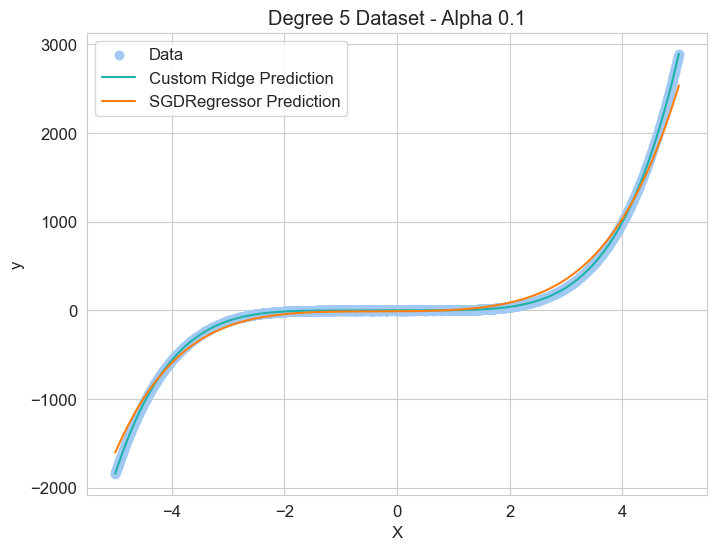

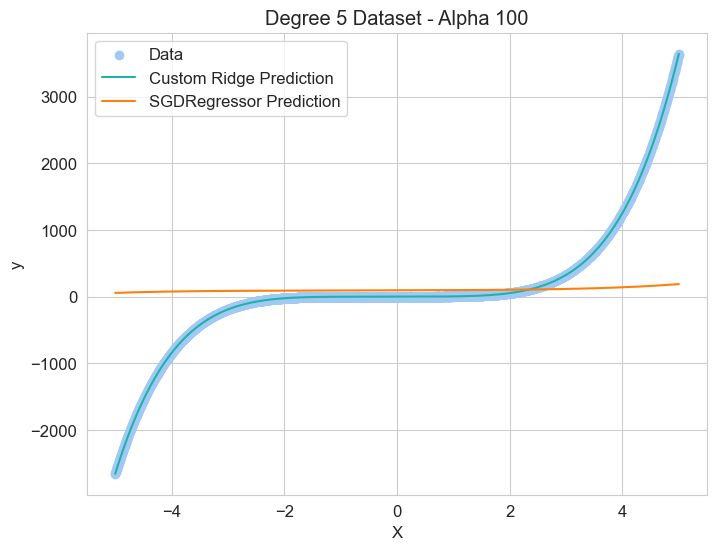

Degree 6 Dataset
Regularization strength (alpha): 0
Custom Ridge Coefficients (w): [0.86592209 0.01052745 0.98844399 0.00144063 0.20624068 0.62021935]
Sklearn Ridge Coefficients (w): [0.86592209 0.01052745 0.98844399 0.00144063 0.20624068 0.62021935]
SGD Coefficients (w): [-1.11666740e+00 -1.79555785e+02  5.76520665e+01  4.84533605e+02
  1.86583582e+02  1.99317772e+03]
MSE (Custom): 1.049
MSE (SGD): 660.969
--------------------------------------------------
Degree 6 Dataset
Regularization strength (alpha): 0.1
Custom Ridge Coefficients (w): [0.27992822 0.7349969  0.77054497 0.59998225 0.93902167 0.11565203]
Sklearn Ridge Coefficients (w): [0.27992822 0.7349969  0.77054497 0.59998225 0.93902167 0.11565203]
SGD Coefficients (w): [ 17.4188727   59.43430662 339.39592985 188.71126038 523.07567634
 265.41946709]
MSE (Custom): 0.974
MSE (SGD): 11288.629
--------------------------------------------------
Degree 6 Dataset
Regularization strength (alpha): 100
Custom Ridge Coefficients (w): [0.70

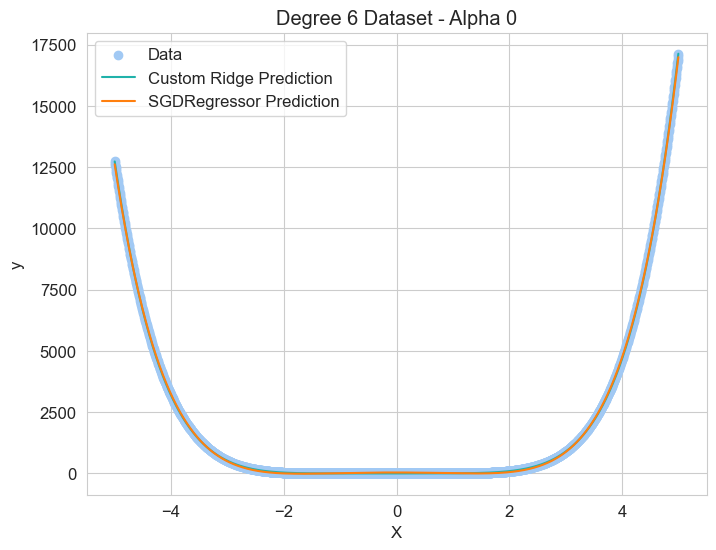

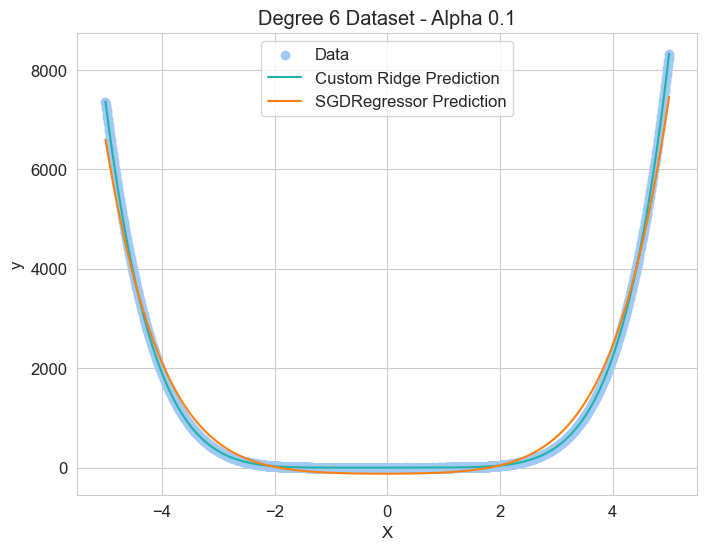

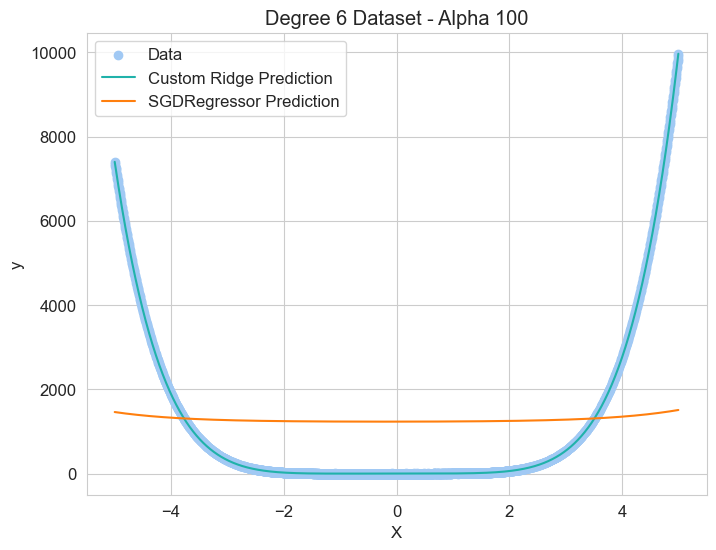

In [231]:
# Define regularization strengths
alphas = [0, 0.1, 100]
num_sample = 2000

# Loop through different polynomial degrees
for n in range(4,7): # Compare degree into 4, 5, 6
    results_n = model_comparison(n, num_sample, alphas)
    
    for res in results_n:
        _, _, _, _, alpha, coef_custom, coef_ridge, coef_sgd, mse_custom, mse_sgd = res
        print(f"Degree {n} Dataset")
        print(f"Regularization strength (alpha): {alpha}")
        print("Custom Ridge Coefficients (w):", coef_custom)
        print("Sklearn Ridge Coefficients (w):", coef_ridge)
        print("SGD Coefficients (w):", coef_sgd)
        print(f"MSE (Custom): {mse_custom:.3f}")
        print(f"MSE (SGD): {mse_sgd:.3f}")
        print("-" * 50)


    # Plot the Compare models on three toy datasets
    plot_model_comparison(n, num_sample, alphas)



#### (a) How does your implementation compare to SGDRegressor?

从结果看出：

你的实现和 sklearn.Ridge 的结果完全一致，说明你实现的解析解是正确的！👍

而 SGDRegressor 的结果波动非常大，尤其是高阶多项式（degree 5、6）和较大的 α 时，系数变得非常不稳定、巨大，MSE（均方误差）也急剧上升。
高 alpha → 权重惩罚过强 → 模型太简单 → 欠拟合
在我的实验中，我观察到当 alpha 值增大时，SGDRegressor 的预测曲线逐渐变得平坦，最终几乎成为一条直线。这表明模型被强烈正则化，丧失了对输入数据的敏感性，无法有效地捕捉数据的多项式关系。这是一种明显的欠拟合现象，说明过大的 alpha 值会严重影响模型的预测能力。


✨ 原因分析：
SGD 本质是近似解法：它是通过随机梯度下降来逼近最优解的，不一定每次都能收敛到最优，特别是：

特征没标准化好

学习率/超参数没调好

特征维度过高时（如多项式6阶以上）

你的解析解是精确计算的闭式解，计算得到的是全局最优解（没有浮动）。

✅ 结论：
在这种小规模、特征数可控的实验中，你的实现更稳定、更可靠。

SGD 需要良好的调参和标准化，否则容易失控。


#### (b) Which implementation do you expect to be faster to fit? What about for making predictions? Can you observe this on your datasets?

1. 训练时间对比：
你的实现（闭式解）：一次矩阵求逆（(X^T X + αI)^-1 X^T y），复杂度高，但对于小数据集来说非常快。

SGDRegressor：迭代式优化，复杂度线性随样本和特征增加，每次训练都要多轮迭代。

👉 所以对于小数据集：

➤ 你的闭式解实现 更快！

而对于超大数据集（比如几百万条数据）：

➤ 解析解可能 内存不够/计算量过大，SGD 就会更合适。

2. 预测速度对比：
预测时计算 X @ w + b：

无论是你实现的、sklearn 的，还是 SGD，只要权重 w 拿到以后，预测都是一次矩阵乘法。

所以预测速度几乎没有区别。

#### Conclusion:



## Part 2: Support Vector Classifier
### Task 4.1: Load the dataset

In [75]:
# Setup Evironment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
print("Environment setup complete")

# read data
coloums = ['ID', 'Diagnosis',
           'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 
           'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2',
           'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
data = pd.read_csv('wdbc.data', names=coloums)
print("Load the dataset success.")

Environment setup complete


### Task 4.2: Basic exploratory data analysis

#### Display basic information about the dataset

In [16]:
print(data.head())
data.info()

# Check for missing value
missing_values = data.isnull().sum()
print("The number of missing values:\n", missing_values)

# Count the number of occurrences of each diagnosis type
diagnosis_count = data['Diagnosis'].value_counts()
print("numbers of diffirent Diagnosis type:\n", diagnosis_count)

# Check if the dataset is imbalanced (if greater than 10, it's considered imbalanced)
is_imbalanced = diagnosis_count.max() / diagnosis_count.min() > 10
print("Is the data imbalanced: ", is_imbalanced)


         ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  radius3  texture3  \
0       0.27760      0.3001          0.14710  ...    25.38     17.33   
1       0.07864      0.0869          0.07017  ...    24.99     23.41   
2       0.15990      0.1974          0.12790  ...    23.57     25.53   
3       0.28390      0.2414          0.10520  ...    14.91     26.50   
4       0.13280      0.1980          0.10430  ...    22.54     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0      184.60  2019.0  

#### visualisa the data

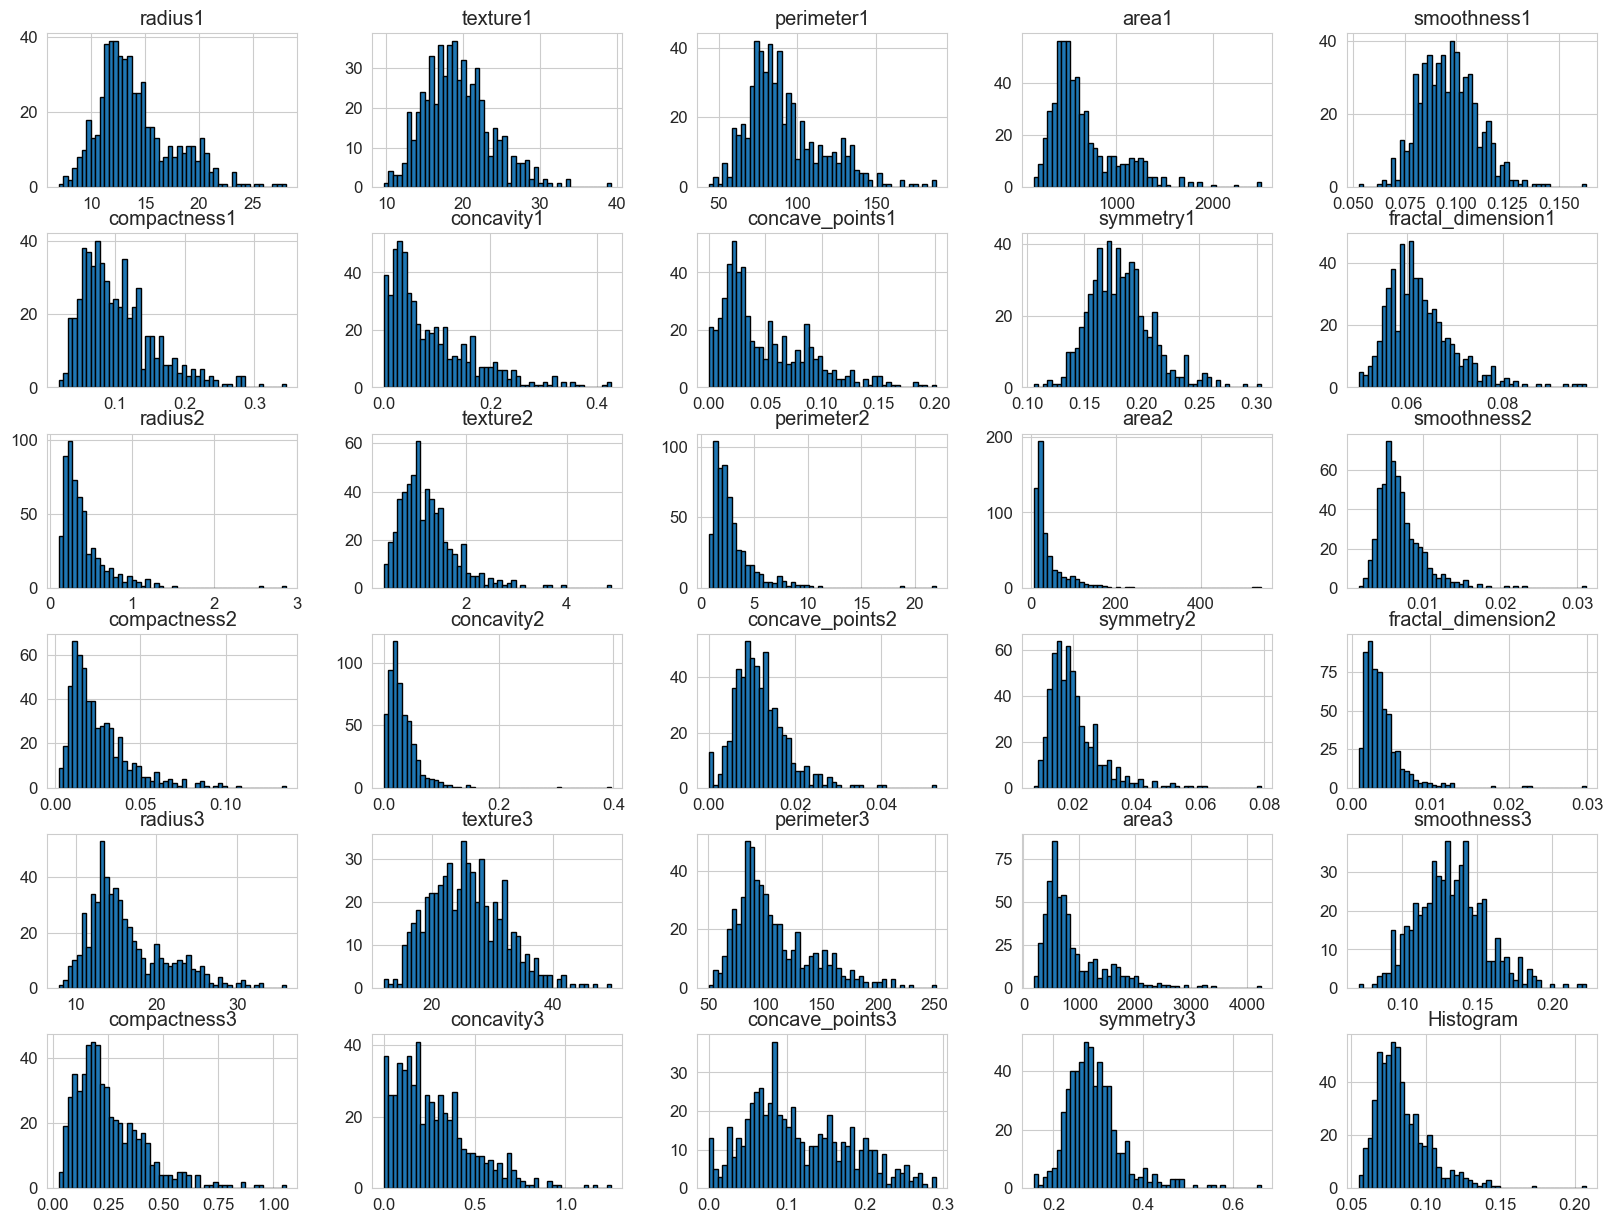

In [83]:
# Drop the non-numeric columns
numeric_data = data.drop(columns=['ID']).drop(columns=['Diagnosis'])

# Plot histograms for the numeric data
numeric_data.hist(bins=50, figsize=(20, 15), edgecolor='black') 
plt.title('Histogram')     
plt.show()

#### Check the correlation between features

In [118]:

# Compute the correlation matrix for the numeric features
correlation_matrix = numeric_data.corr()
print("Correlation between features:\n")
print(correlation_matrix)


# Define a threshold to filter out highly correlated features
threshold = 0.9

high_corr_columns = set()
high_corr_pairs = set()

# Iterate through the correlation matrix to find pairs with correlation greater than the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_columns.add(colname)
            
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.add((colname, colname_j))

# Print the highly correlated columns and pairs
print("High correlation columns (correlation > 0.9):")
print(high_corr_columns)

print("High correlation pairs (correlation > 0.9):")
for pair in high_corr_pairs:
    print(pair)

Correlation between features:

                     radius1  texture1  perimeter1     area1  smoothness1  \
radius1             1.000000  0.323782    0.997855  0.987357     0.170581   
texture1            0.323782  1.000000    0.329533  0.321086    -0.023389   
perimeter1          0.997855  0.329533    1.000000  0.986507     0.207278   
area1               0.987357  0.321086    0.986507  1.000000     0.177028   
smoothness1         0.170581 -0.023389    0.207278  0.177028     1.000000   
compactness1        0.506124  0.236702    0.556936  0.498502     0.659123   
concavity1          0.676764  0.302418    0.716136  0.685983     0.521984   
concave_points1     0.822529  0.293464    0.850977  0.823269     0.553695   
symmetry1           0.147741  0.071401    0.183027  0.151293     0.557775   
fractal_dimension1 -0.311631 -0.076437   -0.261477 -0.283110     0.584792   
radius2             0.679090  0.275869    0.691765  0.732562     0.301467   
texture2           -0.097317  0.386358   -0.0

As observed above, there is a multicollinearity issue in the data, which cannot be easily resolved by deleting features. Therefore, we choose to use a regularized model to handle this.
#### Plot the correlation heat map

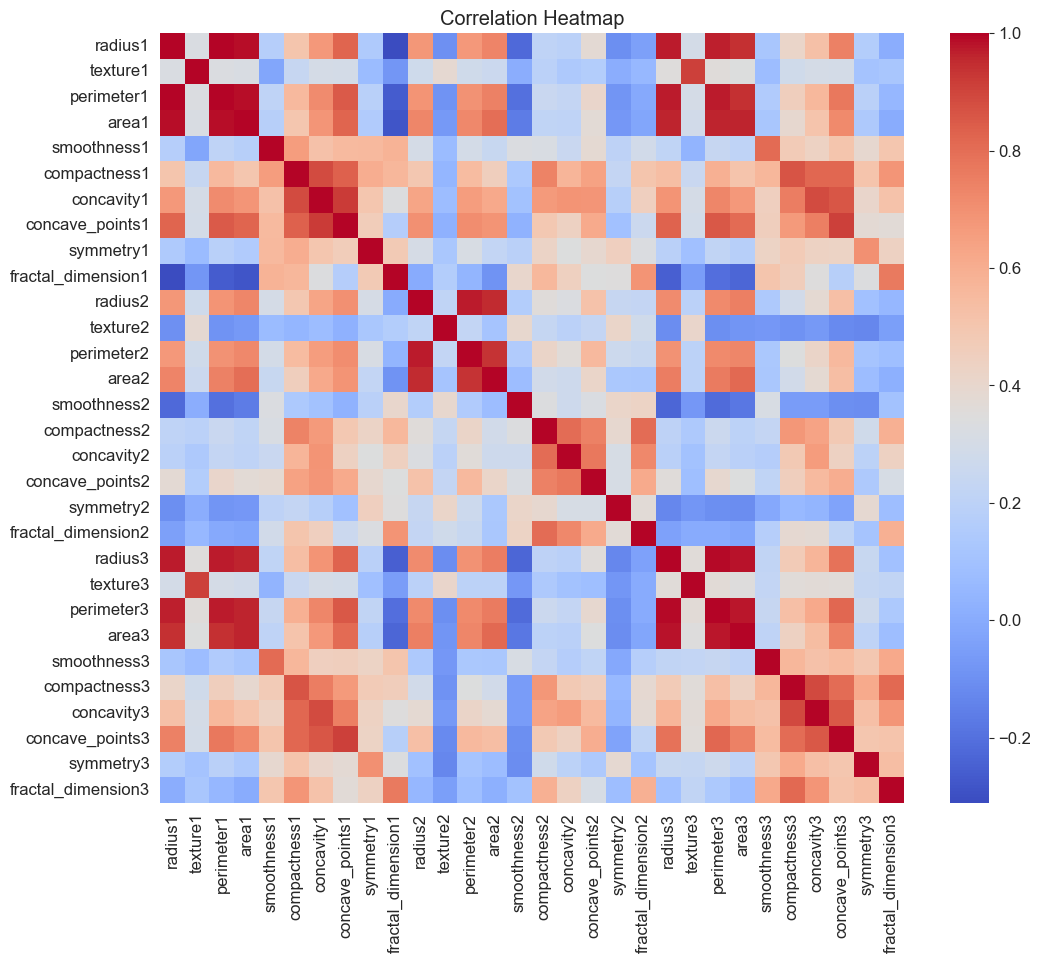

In [80]:
plt.figure(figsize=(12, 10))  
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sns.pairplot(correlation_matrix)
plt.show()

### Task 4.3：Split the dataset into a training and testing set

In [100]:

from sklearn.model_selection import train_test_split

X = numeric_data
y = data['Diagnosis'].map({'B': 0, 'M': 1}) #正类是指我们希望关注的类别，恶性肿瘤（M）

# 8/2 split, need to stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We do need to stratify your split.
The dataset has two classes: 'B' (benign) and 'M' (malignant). From the task 2 we found the dataset is imbalanced, using stratify=y helps to maintain the same ratio of 'B' and 'M' in both the training and test sets. Without it, there's a risk that the data split could result in training or test sets with a disproportionate number of samples from one class, which could affect the model's ability to learn and generalize well.

### Task 4.4: Use a sklearn.svm.SVC model

In [134]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC  
import numpy as np

# Create a pipeline with MinMax scaling and Support Vector Classifier (SVC)
pipe = Pipeline([
    ('scaler', MinMaxScaler()),  # MinMax scaling helps SVC perform better since it is sensitive to feature magnitudes.
    ('svc', SVC(probability=True))  # For output class probabilities
])

# Define the parameter grid to search over for hyperparameter tuning
param_grid = {
    'svc__C': np.logspace(0.1, 1, 10),  # Regularization strength
    'svc__kernel': ['linear', 'rbf', 'poly'],  # Test different kernel types (linear, radial basis function, polynomial)
}

# Set up GridSearchCV for hyperparameter tuning using 5-fold stratified cross-validation
# Optimize F1-score
model_f1 = GridSearchCV(
    estimator=pipe,  
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Stratified K-fold for maintaining class distribution in each fold
    scoring='f1_weighted',  # Use weighted F1 score for evaluation during tuning
    refit=True,  
)

# Fit the model with the training data
model_f1.fit(X_train, y_train)  # X_train: training features, y_train: training labels


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': array([ 1.25892541,  1.58489319,  1.99526231,  2.51188643,  3.16227766,
        3.98107171,  5.01187234,  6.30957344,  7.94328235, 10.        ]),
                         'svc__kernel': ['linear', 'rbf', 'poly']},
             scoring='f1_weighted')

In [135]:
# Optimize Recall
model_recall = GridSearchCV(
    estimator=pipe,  
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Stratified K-fold for maintaining class distribution in each fold
    scoring='recall_weighted',  # Use weighted F1 score for evaluation during tuning
    refit=True,  
)

# Fit the model with the training data
model_recall.fit(X_train, y_train)  # X_train: training features, y_train: training labels

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': array([ 1.25892541,  1.58489319,  1.99526231,  2.51188643,  3.16227766,
        3.98107171,  5.01187234,  6.30957344,  7.94328235, 10.        ]),
                         'svc__kernel': ['linear', 'rbf', 'poly']},
             scoring='recall_weighted')

#### (a) Do you need to stratify your cross-validation?
Yes, because stratified cross-validation keeps the class distribution balanced in each fold. This gives more reliable results, especially when the data is imbalanced.

#### (b) What scoring metric is most appropriate for this task?
**F1-score**
Since the dataset is imbalanced (benign tumors are more common than malignant ones), using F1 Weighted is a suitable option because it considers all classes proportionally, balancing precision and recall.

**Recall**
In medical diagnoses like breast cancer detection, missing a malignant tumor (false negative) can be far more dangerous than a false alarm (false positive).
Therefore, Recall becomes more important than Precision — it's better to raise a false alarm than to miss a diagnosis.

**Performance Comparison**
After the following Task 5, I found both models:

F1 Weighted on Test Set: 0.973

Recall on Test Set: 0.974

Accuracy on Test Set: 0.974

The model optimized for Recall shows a slightly higher ability to detect true positive cases (malignant tumors).
This indicates it is more effective at minimizing false negatives, which is crucial in healthcare applications.

**Conclusion**
Because minimizing false negatives is the priority in this scenario, the model optimized for **Recall** is the better choice.


#### (c) What hyperparameters did you choose? How many models did you fit in total?
3 values for C (np.logspace(0.1, 1, 10) produces 10 values, so 10 choices for C)
3 types of kernels ('linear', 'rbf', 'poly')

In total, the number of models fitted would be:
10 values for C × 3 kernels = 30 models.

#### (d) Present your results for the optimal hyperparameter combination.

In [141]:
# Display the best hyperparameters
print("Best hyperparameters (F1 Weighted):", model_f1.best_params_)
print("Best hyperparameters (Recall):", model_recall.best_params_)


# Display the best score which obtained through cross-validation
print("Best score (F1 Weighted):", model_f1.best_score_)
print("Best score (Recall):", model_recall.best_score_)

Best hyperparameters (F1 Weighted): {'svc__C': 7.943282347242816, 'svc__kernel': 'rbf'}
Best hyperparameters (Recall): {'svc__C': 7.943282347242816, 'svc__kernel': 'rbf'}
Best score (F1 Weighted): 0.9823424673545513
Best score (Recall): 0.9824175824175825


### Task 4.5: Evaluate the model on the test set
#### The best model based on the F1-score

F1 Weighted on Test Set: 0.973
Accuracy on Test Set: 0.974


Text(0.5, 1.0, 'SVC(F1 Model test)')

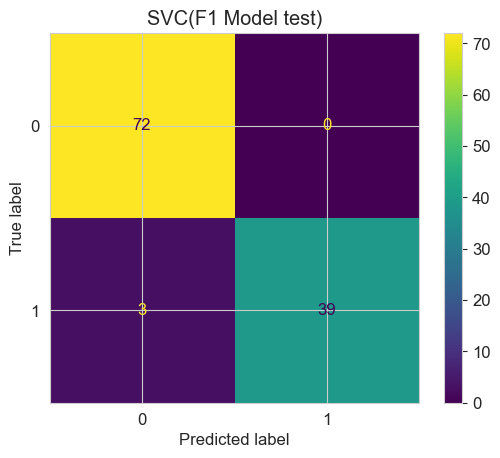

In [138]:

best_model = model_f1.best_estimator_

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)

# Calculate and print the F1 weighted score on the test set
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Weighted on Test Set: {test_f1:.3f}")

# Calculate and print the accuracy on the test set
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_test_pred):.3f}")


# Display the confusion matrix for the test set predictions
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
disp.ax_.set_title('SVC(F1 Model test)')


#### The best model based on the Recall

Recall on Test Set: 0.974
Accuracy on Test Set: 0.974


Text(0.5, 1.0, 'SVC (Recall Model Test)')

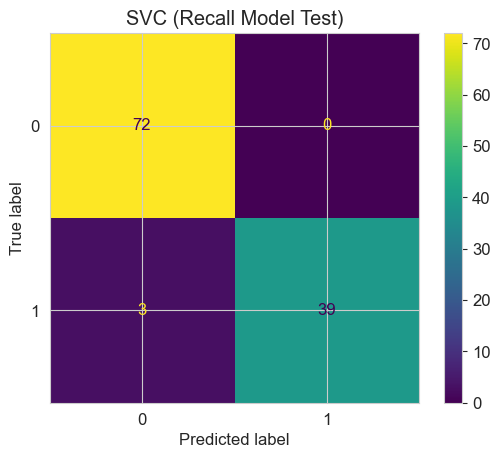

In [137]:

best_model = model_recall.best_estimator_

# Evaluation
from sklearn.metrics import recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)

# Calculate and print the Recall score on the test set
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f"Recall on Test Set: {test_recall:.3f}")

# Calculate and print the accuracy on the test set
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_test_pred):.3f}")

# Display the confusion matrix for the test set predictions
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
disp.ax_.set_title('SVC (Recall Model Test)')


### Task 4.6
#### (a) Would you be confident in implementing this for real-world breast cancer screening? Explain your reasoning.

I would be **cautiously optimistic**, but **not fully confident** in directly applying this model to real-world breast cancer screening without further validation and testing.

#### Reasons:

1. **Promising Performance**:  
   The model achieved a **Recall of 0.974** and an **Accuracy of 0.974** on the test set, which indicates that it performs well in detecting malignant tumors. This is important because in medical diagnosis, especially cancer screening, it is crucial not to miss any malignant cases.

2. **Good Generalization**:  
   The cross-validation score (Recall: 0.982) is close to the test score (0.974), showing that the model is not overfitting and has good generalization ability.

3. **Limitations of the Dataset**:  
   The dataset used might not fully represent the complexity and diversity of real-world data (e.g., imaging data, demographic variation, or noisy/incomplete data). This model was trained on structured, clean data, which may not reflect real-world scenarios.

4. **Need for Clinical Validation**:  
   Before deployment, the model should be validated on larger, real-world datasets and tested in clinical environments under expert supervision. It should also be integrated into a broader diagnostic system that includes human decision-making.

#### Conclusion:
The model shows strong potential and could assist in **supporting** real-world breast cancer screening. However, I would **not deploy it as a standalone tool** without further clinical testing and safety validation.

#### (b) Recision/Recall Curves

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



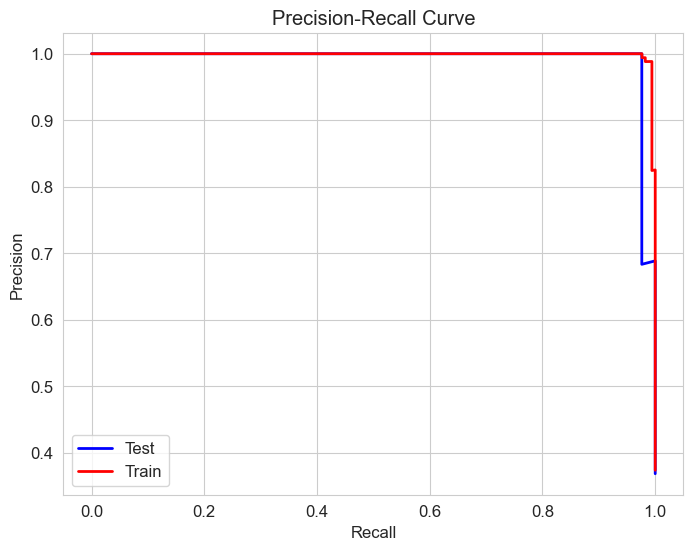

In [145]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class (class 1)
y_test_probs = best_model.predict_proba(X_test)[:, 1]  
y_train_probs = best_model.predict_proba(X_train)[:, 1]  


# Compute precision and recall values
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_probs)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))


# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, label='Test', color='blue', lw=2)
plt.plot(recall_train, precision_train, label='Train', color='red', lw=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()

plt.show()


#### Explanation
Yes, recision/recall curves is very useful, especially in cases of imbalanced binary classification problems, such as this breast cancer detection.

The curve typically shows

As recall increases, precision decreases: This is a common trend in a PR curve, showing the trade-off between the two metrics.

When the recall is 0.98, precision is still at 0.68, indicating this model maintains a good balance between high recall and moderately high precision, which is overall good performance.

Eventually, the curve drops to (1, 0.2), revealing if we push for an extreme recall of "miss nothing," there will be a lot of false positives;
This could lead to unnecessary panic or further tests for patients.

**In summary:**
This curve demonstrates that your model performs well in balancing precision and recall, especially when recall is 0.98, maintaining relatively high precision, which is suitable for tasks where missing cases is highly sensitive, such as breast cancer screening.

---

In breast cancer screening, malignant tumors (positive class) are the minority class, but they are the most important to detect.

**Accuracy** in this context can be misleading (for example, a model that always predicts "benign" could still achieve a high accuracy).

**Precision** tells us: out of all the samples predicted as "malignant," how many are actually malignant.

**Recall** tells us: out of all the actual "malignant" samples, how many are correctly identified by the model.

**PR Curve (Precision-Recall Curve)** provides a clearer view of the model's ability to detect the positive class, and is more suitable for imbalanced datasets than the ROC curve.
#### Precision, Recall, and F1-Score on Test Set Evaluation
- **Precision for class 0 (Benign)**: 96% – Out of all the predictions made for benign, 96% were accurate.
- **Recall for class 0 (Benign)**: 100% – The model identified all benign cases correctly.
  
- **Precision for class 1 (Malignant)**: 100% – Out of all the predictions made for malignant, 100% were accurate.
- **Recall for class 1 (Malignant)**: 93% – The model correctly identified 93% of malignant cases.

- **Accuracy**: 97% – Overall, the model correctly classified 97% of the samples.